In [1]:
import argparse
import json
import os
import warnings
import sys
sys.path.append('../')
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import numpy as np
from models.modular_compositional_models import *
from domains.synthetic_data_sampler import SyntheticDataSampler
from models.end_to_end_modular_models import *
from models.MoE import *
from models.utils import *
from exp_utils import *
warnings.filterwarnings('ignore')
from econml.metalearners import XLearner, TLearner, SLearner
from sklearn.ensemble import RandomForestRegressor
from econml.dml import NonParamDML


def x_learner(df, covariates, treatment, outcome, X_test = None, output_scaler=None):
    # Split the data into features, treatment, and outcome
    X = df[covariates].values
    
    if len(covariates) == 1:
        X = X.reshape(-1, 1)
    
    T = df[treatment].values
    Y = df[outcome].values   
    est = XLearner(models=[RandomForestRegressor(n_estimators=100), RandomForestRegressor(n_estimators=100)])
    est.fit(Y, T, X=X)

    # if X_test is None, then evaluate on the training data
    if X_test is None:
        X_test = X
    else:
    # otherwise evaluate on the test data
        X_test = X_test[covariates].values
        if len(covariates) == 1:
            X_test = X_test.reshape(-1, 1)
    causal_effect_estimates = est.effect(X_test)

    # scale back the output if output_scaler is provided
    if output_scaler is not None:
        causal_effect_estimates = output_scaler.inverse_transform(causal_effect_estimates.reshape(-1, 1)).flatten()
    
    return causal_effect_estimates

def s_learner(df, covariates, treatment, outcome, X_test = None, output_scaler=None):
    # Split the data into features, treatment, and outcome
    X = df[covariates].values
    
    if len(covariates) == 1:
        X = X.reshape(-1, 1)
    
    T = df[treatment].values
    Y = df[outcome].values   
    est = XLearner(models=RandomForestRegressor(n_estimators=100))
    est.fit(Y, T, X=X)

    # if X_test is None, then evaluate on the training data
    if X_test is None:
        X_test = X
    else:
    # otherwise evaluate on the test data
        X_test = X_test[covariates].values
        if len(covariates) == 1:
            X_test = X_test.reshape(-1, 1)
    causal_effect_estimates = est.effect(X_test)

    # scale back the output if output_scaler is provided
    if output_scaler is not None:
        causal_effect_estimates = output_scaler.inverse_transform(causal_effect_estimates.reshape(-1, 1)).flatten()
    
    return causal_effect_estimates

def t_learner(df, covariates, treatment, outcome, X_test = None, output_scaler=None):
    # Split the data into features, treatment, and outcome
    X = df[covariates].values
    
    if len(covariates) == 1:
        X = X.reshape(-1, 1)
    
    T = df[treatment].values
    Y = df[outcome].values   
    est = TLearner(models=[RandomForestRegressor(n_estimators=100), RandomForestRegressor(n_estimators=100)])
    est.fit(Y, T, X=X)

    # if X_test is None, then evaluate on the training data
    if X_test is None:
        X_test = X
    else:
    # otherwise evaluate on the test data
        X_test = X_test[covariates].values
        if len(covariates) == 1:
            X_test = X_test.reshape(-1, 1)
    causal_effect_estimates = est.effect(X_test)

    # scale back the output if output_scaler is provided
    if output_scaler is not None:
        causal_effect_estimates = output_scaler.inverse_transform(causal_effect_estimates.reshape(-1, 1)).flatten()
    
    return causal_effect_estimates

def non_param_DML(df, covariates, treatment, outcome, X_test = None, output_scaler=None):
    # Split the data into features, treatment, and outcome
    X = df[covariates].values
    T = df[treatment].values
    Y = df[outcome].values

    est = NonParamDML(model_y=RandomForestRegressor(n_estimators=100, max_depth=10),
                  model_t=RandomForestRegressor(n_estimators=100, max_depth=10),
                  model_final=RandomForestRegressor(n_estimators=100, max_depth=10))
    est.fit(Y, T, X=X)

    # if X_test is None, then evaluate on the training data
    if X_test is None:
        X_test = X
    else:
    # otherwise evaluate on the test data
        X_test = X_test[covariates].values
    
    causal_effect_estimates = est.effect(X_test, T0=0, T1=1)
    # scale back the output if output_scaler is provided
    if output_scaler is not None:
        causal_effect_estimates = output_scaler.inverse_transform(causal_effect_estimates.reshape(-1, 1)).flatten()

    # this method only returns the effect estimates
    return causal_effect_estimates

def random_forest(df, covariates, treatment, outcome, X_test=None, output_scaler=None):
    # Split the data into features, treatment, and outcome
    X = df[covariates].values
    T = df[treatment].values
    Y = df[outcome].values
    print(X.shape, T.shape, Y.shape)

    # concatenate the features and treatment
    X_T = np.concatenate([X, T[:, None]], axis=1)
    # Fit the random forest models
    est = RandomForestRegressor(n_estimators=100, max_depth=10)
    est.fit(X_T, Y)

    if X_test is None:
        X_test = X
    else:
        X_test = X_test[covariates].values
    X_0 = np.concatenate([X_test, np.zeros((X_test.shape[0], 1))], axis=1)
    X_1 = np.concatenate([X_test, np.ones((X_test.shape[0], 1))], axis=1)
    # Predict the outcomes
    y1 = est.predict(X_1)
    y0 = est.predict(X_0)

    if output_scaler is not None:
        y1 = output_scaler.inverse_transform(y1.reshape(-1, 1)).flatten()
        y0 = output_scaler.inverse_transform(y0.reshape(-1, 1)).flatten()
    causal_effect_estimates = y1 - y0

    return causal_effect_estimates, y1, y0

args = parse_arguments(jupyter=True)


all_results = {}
all_results_train_size = {}
noise = 1
# num_train_modules = list(range(2, args.num_modules + 1))
num_train_modules = [args.num_modules]

exp = "CG"
variable = num_train_modules[0]

/home/ppruthi_umass_edu/.local/lib/python3.8/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (2.2.3) or chardet (None)/charset_normalizer (3.1.0) doesn't match a supported version!
  warnings.warn(


In [2]:
for key, value in vars(args).items():
    print(key, ' : ', value)

domain  :  synthetic_data
biasing_covariate  :  feature_sum
bias_strength  :  0
scale  :  False
num_modules  :  10
num_feature_dimensions  :  1
num_samples  :  10000
composition_type  :  hierarchical
resample  :  True
seed  :  45
fixed_structure  :  False
data_dist  :  uniform
heterogeneity  :  1.0
split_type  :  ood
hidden_dim  :  64
epochs  :  100
batch_size  :  64
output_dim  :  1
covariates_shared  :  False
underlying_model_class  :  MLP
run_env  :  unity
use_subset_features  :  False
systematic  :  True
test_size  :  0.8
model_misspecification  :  False


In [3]:
if exp == "noise":
        train_modules = args.num_modules - 1
        noise = variable
else:
    noise = 0
    train_modules = variable
all_results[str(variable)] = {}
all_results_train_size[str(variable)] = []

main_dir, csv_path, obs_data_path, scaler_path = setup_directories(args)
# module_function_types = [f"f{i+1}" for i in range(args.num_modules)]
module_function_types = ["polyval"] * args.num_modules
sampler = SyntheticDataSampler(args.num_modules, args.num_feature_dimensions, args.composition_type, 
                                args.fixed_structure, args.num_modules, args.num_samples, args.seed, 
                                args.data_dist, module_function_types=module_function_types, resample=args.resample,
                                heterogeneity=args.heterogeneity, covariates_shared=args.covariates_shared, 
                                use_subset_features=args.use_subset_features, systematic=args.systematic, 
                                run_env=args.run_env, noise = noise)
print(sampler.csv_folder)
# first sample the data and prepare it
data, df_sampled = simulate_and_prepare_data(args, sampler, csv_path, obs_data_path, scaler_path, num_train_modules=train_modules, test_on_last_depth=True)


num_modules:  10
Reinitializing path 0
Reinitializing path 1
Reinitializing csv folder
/work/pi_jensen_umass_edu/ppruthi_umass_edu/compositional_models_cate/domains/synthetic_data/csvs/fixed_structure_False_outcomes_hierarchical_systematic_True
Resampling data
Generating input trees
Generating input trees
Generating trees for group size: 2
Number of combinations: 45
Group size: 2, Number of trees: 3960
Generating trees for group size: 3
Number of combinations: 120
Group size: 2, Number of trees: 3960
Group size: 3, Number of trees: 3960
Generating trees for group size: 4
Number of combinations: 210
Group size: 2, Number of trees: 3960
Group size: 3, Number of trees: 3960
Group size: 4, Number of trees: 3990
Generating trees for group size: 5
Number of combinations: 252
Group size: 2, Number of trees: 3960
Group size: 3, Number of trees: 3960
Group size: 4, Number of trees: 3990
Group size: 5, Number of trees: 3780
Generating trees for group size: 6
Number of combinations: 210
Group siz

In [4]:
if args.composition_type == "hierarchical":
    # do one hot encoding for the order of modules
    # data = pd.concat([data, pd.get_dummies(data["order_of_modules"], prefix="module_order")], axis=1)
    # df_sampled = pd.concat([df_sampled, pd.get_dummies(df_sampled["order_of_modules"], prefix="module_order")], axis=1)
    # order_of_modules is a string "2_3_1", convert it to a list [2, 3, 1] and make it separate columns
    data["order_of_modules"] = data["order_of_modules"].apply(lambda x: [int(i) for i in x.split("_")])
    data = pd.concat([data, pd.DataFrame(data["order_of_modules"].to_list(), columns=[f"module_{i+1}_order" for i in range(args.num_modules)])], axis=1)

    df_sampled["order_of_modules"] = df_sampled["order_of_modules"].apply(lambda x: [int(i) for i in x.split("_")])
    df_sampled = pd.concat([df_sampled, pd.DataFrame(df_sampled["order_of_modules"].to_list(), columns=[f"module_{i+1}_order" for i in range(args.num_modules)])], axis=1)

    # get the order of modules per query_id
    module_order = {}
    for qid, order in zip(df_sampled["query_id"], df_sampled["order_of_modules"]):
        module_order[qid] = order

    # # drop the order_of_modules column
    data.drop(columns=["order_of_modules"], inplace=True)
    df_sampled.drop(columns=["order_of_modules"], inplace=True)

    if args.systematic:
        # replace NaN module orders with 0
        for i in range(1, args.num_modules + 1):
            data[f"module_{i}_order"].fillna(0, inplace=True)
            df_sampled[f"module_{i}_order"].fillna(0, inplace=True)

        

# Load train and test qids
train_qids, test_qids = load_train_test_qids(csv_path, args)

covariates = [x for x in df_sampled.columns if "feature_0" in x] if args.covariates_shared else [x for x in df_sampled.columns if "feature" in x]
module_feature_covariates = [x for x in df_sampled.columns if "feature_0" in x] if args.covariates_shared else [x for x in df_sampled.columns if "feature" in x]

    # remove any output features
    
if args.systematic:
    covariates += [x for x in df_sampled.columns if "num" in x]

if args.composition_type == "hierarchical":
    covariates += [x for x in df_sampled.columns if "order" in x]
    
    covariates = [x for x in covariates if "output" not in x]
    module_feature_covariates = [x for x in module_feature_covariates if "output" not in x]

if args.model_misspecification:
    covariates = [x for x in covariates if "feature_0" not in x]


# Scale data
if args.scale:
    data, df_sampled = scale_df(data, df_sampled, scaler_path, csv_path, composition_type=args.composition_type, covariates=covariates,data_dist=args.data_dist)

# Load train and test data
train_df, test_df, train_qids, test_qids = load_train_test_data(csv_path, args, df_sampled)

train_df, test_df = process_shared_covariates_row_wise(train_df, test_df, args)

# covariates = [x for x in train_df.columns if "feature" or "order" in x and "output" not in x]
T0_trees = {}
# index trees by query_id
for tree in sampler.processed_trees_0:
    T0_trees[tree["query_id"]] = tree

T1_trees = {}
# index trees by query_id
for tree in sampler.processed_trees_1:
    T1_trees[tree["query_id"]] = tree

# As we have same structure across the query_id, we need only one tree to get the structure.

print(f"Training data shape: {train_df.shape}")
print("Covaariates: ", covariates)
treatment, outcome = "treatment_id", "query_output"

gt_effects_test = get_ground_truth_effects(data, test_qids)
gt_effects_train = get_ground_truth_effects(data, train_qids)


model_effects_train = {}
model_effects_test = {}

input_dim = len(covariates)
if input_dim < args.hidden_dim and args.covariates_shared:
    hidden_dim = args.hidden_dim 
else:
    hidden_dim = (input_dim + 1)*2
models = {
    "XLearner": None,
    "TLearner": None,
    "SLearner": None,
    "RandomForest": None,
    "NonParamDML": None
}
nn_models = { "Baseline": BaselineModel if args.underlying_model_class == "MLP" else BaselineLinearModel}
results = {}

Training data shape: (35600, 54)
Covaariates:  ['module_1_feature_feature_0', 'module_2_feature_feature_0', 'module_3_feature_feature_0', 'module_4_feature_feature_0', 'module_5_feature_feature_0', 'module_6_feature_feature_0', 'module_7_feature_feature_0', 'module_8_feature_feature_0', 'module_9_feature_feature_0', 'module_10_feature_feature_0', 'num_module_1', 'num_module_2', 'num_module_3', 'num_module_4', 'num_module_5', 'num_module_6', 'num_module_7', 'num_module_8', 'num_module_9', 'num_module_10', 'module_1_order', 'module_2_order', 'module_3_order', 'module_4_order', 'module_5_order', 'module_6_order', 'module_7_order', 'module_8_order', 'module_9_order', 'module_10_order']


Training Baseline Model
Training the model on cuda


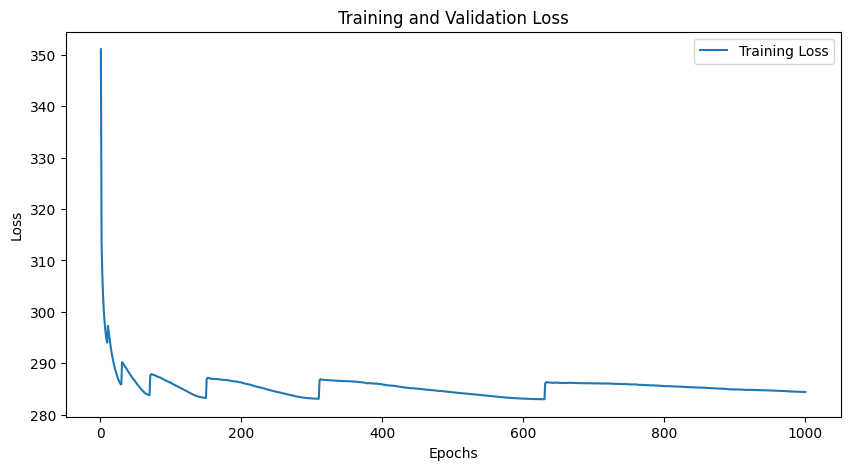

{'Baseline_train': (108.13901781783554, 0.028834155350072943), 'Baseline_test': (122.45704251693411, 0.017576797879015893), 'Catenets_train': (79.16556262674175, 0.28903653790254846), 'Catenets_test': (155.955809178503, -0.25117022503076236)}
Training Catenets Model


In [ ]:
for model_name, model_class in nn_models.items():
    print(f"Training {model_name} Model")
    if model_name == "Baseline":
        model = model_class(input_dim + 1, hidden_dim, args.output_dim)
    else:
        model = model_class(input_dim + 1, hidden_dim, args.output_dim, args.num_modules)
    
    estimated_effects_train, estimated_effects_test = train_and_evaluate_model(
        model, train_df, test_df, covariates, treatment, outcome, args.epochs*10, args.batch_size, args.num_modules, args.num_feature_dimensions, train_qids, test_qids, plot=True, model_name=model_name, scheduler_flag=True
        )
    
    gt_effects_train_values, gt_effects_test_values = np.array(list(gt_effects_train.values())), np.array(list(gt_effects_test.values()))
    estimated_effects_train_values, estimated_effects_test_values = np.array(list(estimated_effects_train.values())), np.array(list(estimated_effects_test.values()))
    results[f"{model_name}_train"] = calculate_metrics(gt_effects_train_values, estimated_effects_train_values)
    results[f"{model_name}_test"] = calculate_metrics(gt_effects_test_values, estimated_effects_test_values)
    model_effects_train[model_name] = estimated_effects_train
    model_effects_test[model_name] = estimated_effects_test

print(results)
# evaluate_train = False

# Catenets
print("Training Catenets Model")
estimated_effects_train, estimated_effects_test = train_and_evaluate_catenets(train_df, test_df, covariates, treatment, outcome, train_qids, test_qids)
gt_effects_train_values, gt_effects_test_values = np.array(list(gt_effects_train.values())), np.array(list(gt_effects_test.values()))
estimated_effects_train_values, estimated_effects_test_values = np.array(list(estimated_effects_train.values())), np.array(list(estimated_effects_test.values()))
results["Catenets_train"] = calculate_metrics(gt_effects_train_values, estimated_effects_train_values)
results["Catenets_test"] = calculate_metrics(gt_effects_test_values, estimated_effects_test_values)
# Add Catenets effects
model_effects_train["Catenets"] = estimated_effects_train
model_effects_test["Catenets"] = estimated_effects_test